**Data Description**

Meteorological data from the HI-SEAS weather station
Duration of four months (September through December 2016) between Missions 4 (IV) and 5 (V).
Source: https://www.kaggle.com/datasets/dronio/SolarEnergy

The units of various columns:

- Solar radiation: watts per meter^2
- Temperature: degrees Fahrenheit
- Humidity: percent
- Barometric pressure: Hg
- Wind direction: degrees
- Wind speed: miles per hour
- Sunrise/sunset: Hawaii time

**TABLE OF CONTENTS:**

1. Library Import and Data Loading

2. Data Preprocessing
    
    a. Checking for null-values
    b. Checking class balance

3. Exploratory Data Analysis:

    a. Correlation Matrix
    b. SelectKBest 
    
5. Feature Engineering:
    
6. Prepping the data for ML

7. Prediction using ML


Our goal is to build a prediction model that efficiently relates independent variables (some already present and some extracted) to predict 'Radiation'.  

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import regex as re

from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler 

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

#!pip install xgboost

import xgboost as xgb
from xgboost import XGBRegressor


In [2]:
# Loading Data etc.

data = pd.read_csv('Solar data.csv')
data.head(3)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Preprocessing

We immediately notice a few things about the data:

1. For the purpose of prediction, we do not care when the data was read/stored, therefore the 'data' column does not need the time. 

2. It is believable that 'Radiation' is dependent upon month, day, hour, minutes (perhaps) - so, we create new columns of those names. 

3. For the same reason, it may be useful to keep track of hours/minutes of Sunrise and Sunset too. 

4. Since we are concerned with predicting 'Solar Radiation', we can filter our data to only those data-points between sunrise and sunset. 

Of course, we also do the usual checking for null-values and imputing them, if any. Most data-types are in the int/float format as expected. We will isolate int type data out of the strings too. 

In [4]:
df = data.copy()

In [5]:
# keeping only the date from the 'data' column

df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [6]:
df.head(2)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00


In [7]:
# creating new columns for month, day, hour, minutes

df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute

In [8]:
df.head(2)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50


In [9]:
print(df['TimeSunRise'].nunique(), df['TimeSunSet'].nunique())

51 56


In [10]:
# Now, for each row, we will record Hour/Minute of Sunrise and Sunset from the TimeSunRise and TimeSunSet (which are originally

# in string format)

#FOR THE FOLLOWING CODE, I HAD TO LOOK UP REGEX at https://regex101.com/

df['SunRiseHour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['SunRiseMinute'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['SunSetHour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['SunSetMinute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)


In [11]:
df.head(2)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,SunRiseHour,SunRiseMinute,SunSetHour,SunSetMinute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,6,13,18,13


Now, we do not need 'TimeSunRise', 'TimeSunSet', 'UNIXTime', 'Data' and 'Time' anymore. 

We are making a minor assumption that 'Seconds' matter very little

In [12]:
df.drop(columns = ['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [13]:
df.head(3)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,SunRiseHour,SunRiseMinute,SunSetHour,SunSetMinute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,6,13,18,13


In [14]:
df.shape # 14 columns in total now

(32686, 14)

In [15]:
df.info() # all data is in numerical format now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Radiation               32686 non-null  float64
 1   Temperature             32686 non-null  int64  
 2   Pressure                32686 non-null  float64
 3   Humidity                32686 non-null  int64  
 4   WindDirection(Degrees)  32686 non-null  float64
 5   Speed                   32686 non-null  float64
 6   Month                   32686 non-null  int32  
 7   Day                     32686 non-null  int32  
 8   Hour                    32686 non-null  int32  
 9   Minute                  32686 non-null  int32  
 10  SunRiseHour             32686 non-null  int32  
 11  SunRiseMinute           32686 non-null  int32  
 12  SunSetHour              32686 non-null  int32  
 13  SunSetMinute            32686 non-null  int32  
dtypes: float64(4), int32(8), int64(2)
memo

In [16]:
# checking for null-values, of which there are none

df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
SunRiseHour               0
SunRiseMinute             0
SunSetHour                0
SunSetMinute              0
dtype: int64

Another point to note is that all the SunRiseHour data is equal to 6.0 and hence not really useful

In [17]:
df['SunRiseHour'].unique()

array([6])

In [18]:
df.drop(columns = ['SunRiseHour'], axis = 1, inplace = True)

SPLITTING OF THE DATA INTO INDEPENDENT and DEPENDENT VARIABLES 

In [19]:
y = df['Radiation']
input_features = df.drop(columns = ['Radiation'], axis = 1)

In [20]:
input_features.head(2)

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,SunRiseMinute,SunSetHour,SunSetMinute
0,48,30.46,59,177.39,5.62,9,29,23,55,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,13,18,13


# Exploratory Data Analysis

We will calculate correlation coefficients between different columns of input_features (say, x and y):

                    r = SUM [(x - mean(x)) * (y - mean(y))] / [ sqrt ( SUM [(x - mean(x))^2 * (y - mean(y))^2] ]
                    
is the correlation coefficient between x and y

In [21]:
corr = df.corr()
corr

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,SunRiseMinute,SunSetHour,SunSetMinute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,-0.000158,0.001052,-0.002215


The correlation in the SunRiseHour is NaN because of division by zero. This can happen if mean is equal to some value, see below

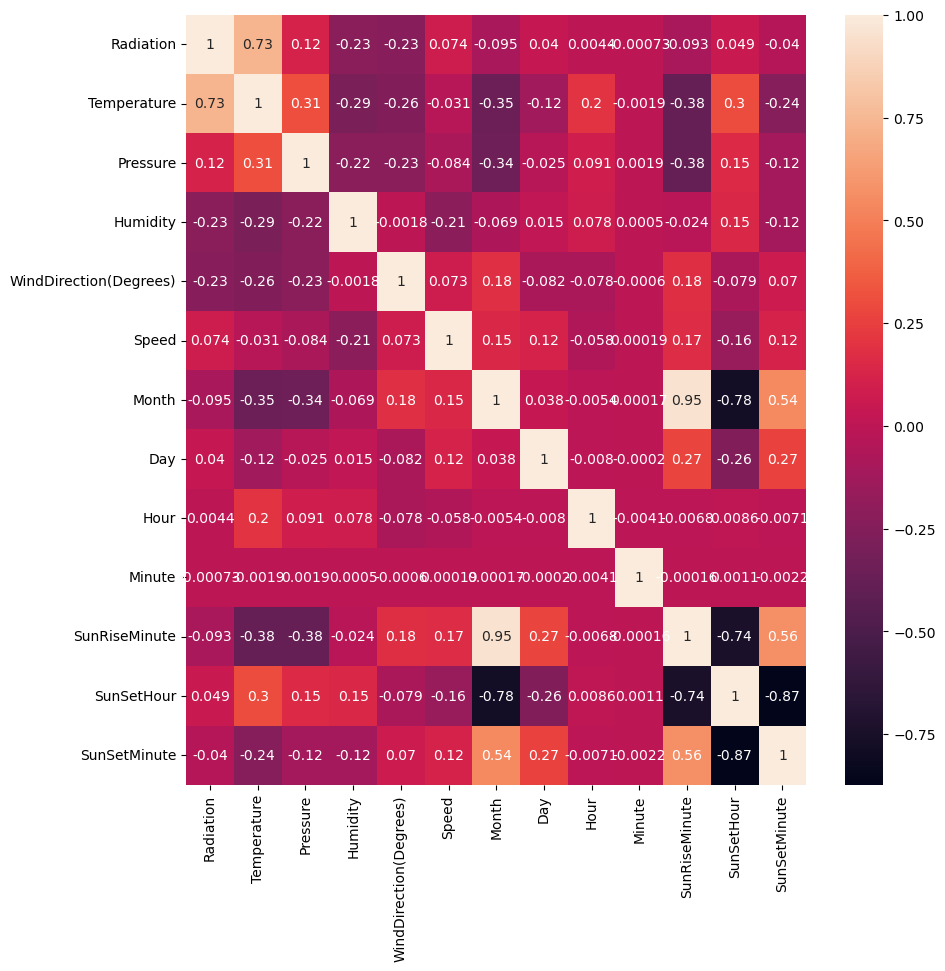

In [22]:
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True)
plt.show()

# Feature Selection with SelectKBest Method

In [23]:
# to use the chi2 as score_func, we will labelencode the data to pass it as continuous parameter

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y)
x_train = MinMaxScaler().fit_transform(input_features) 

In [24]:
k_best_classifier = SelectKBest(score_func = chi2, k = 'all') # 12 features is as high as this goes and we are using the maximum

In [25]:
fitted = k_best_classifier.fit(x_train, y_train)

In [26]:
scores = pd.DataFrame(fitted.scores_)
column = pd.DataFrame(input_features.columns)

In [27]:
# putting them together in a legible manner

featureScores = pd.concat([column, scores], axis=1)

featureScores.columns = ['Features', 'feature_importance'] 

# might as well sort it

featureScores = featureScores.sort_values(by = 'feature_importance', ascending = False)
featureScores

,Features,feature_importance
10,SunSetHour,12289.463887
5,Month,4721.289935
9,SunRiseMinute,4044.452710
3,WindDirection(Degrees),3294.026554
6,Day,2862.204099
8,Minute,2728.507341
11,SunSetMinute,1877.276484
0,Temperature,1655.516161
2,Humidity,1600.068787
4,Speed,771.727960


It may help to hist plot of the feature_importances, for a quick visual inspection

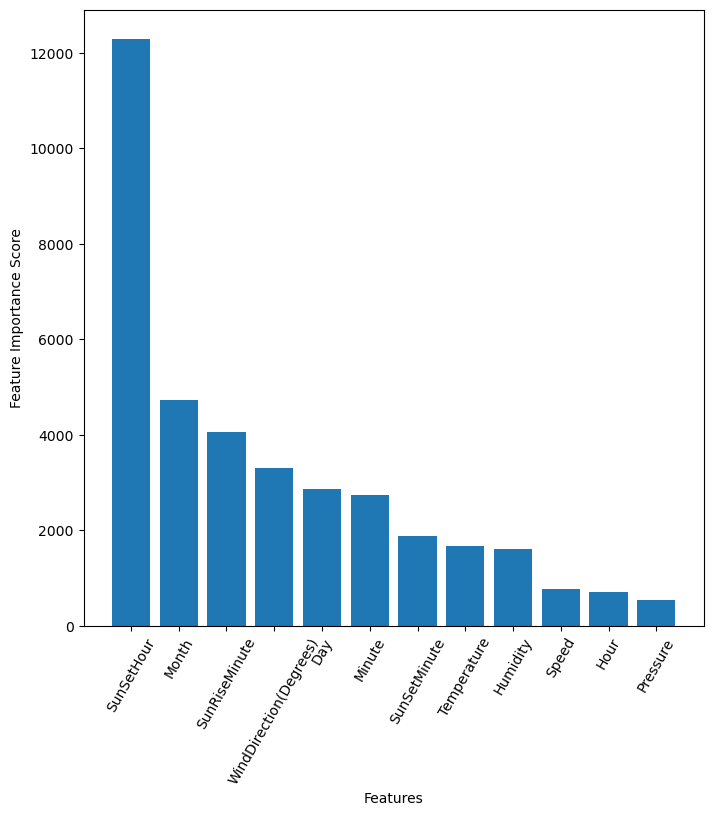

In [28]:
plt.figure(figsize = (8, 8))
plt.bar(x = featureScores['Features'], height = featureScores['feature_importance'])
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation = 60)
plt.show()

# Prepping for ML

In [30]:
# splitting using the 70-30 rule

x_train, x_test, y_train, y_test = train_test_split(input_features, y, test_size = 0.3, random_state = 1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(x_train)
xtest = scaler.transform(x_test)

In [31]:
print(x_train.shape, x_test.shape)

(22880, 12) (9806, 12)


# Predicting with XGBoost

In [32]:
params = {'learning_rate': 0.1, 'max_depth': 8}


xgb_regressor = XGBRegressor(**params)

In [33]:
xgb_regressor.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [34]:
y_predicted = xgb_regressor.predict(x_test)
y_predicted_new = pd.DataFrame(y_predicted)

In [35]:
MSE = mean_squared_error(y_test, y_predicted_new)
R_square_value = r2_score(y_test, y_predicted_new)

print('The mean_squared_error using the XGB Regression is : ', MSE)
print('The R^2 value for the XGB Regression is : ', R_square_value)

The mean_squared_error using the XGB Regression is :  6340.091550362003
The R^2 value for the XGB Regression is :  0.9363485524375373
